이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter10_dl-for-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

# 시계열을 위한 딥러닝

## 다양한 종류의 시계열 작업

## 기온 예측 문제

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-05-10 01:13:37--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.203.248, 52.216.130.53, 52.217.100.118, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.203.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.42MB/s    in 2.4s    

2023-05-10 01:13:40 (5.42 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**예나 날씨 데이터셋 조사하기**

In [4]:
len(lines)

420451

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**데이터 파싱**

In [5]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [8]:
values

[999.82,
 -4.82,
 268.36,
 -8.42,
 75.7,
 4.27,
 3.23,
 1.04,
 2.01,
 3.23,
 1296.38,
 1.23,
 1.96,
 184.9]

**전체 기온을 그래프로 그리기**

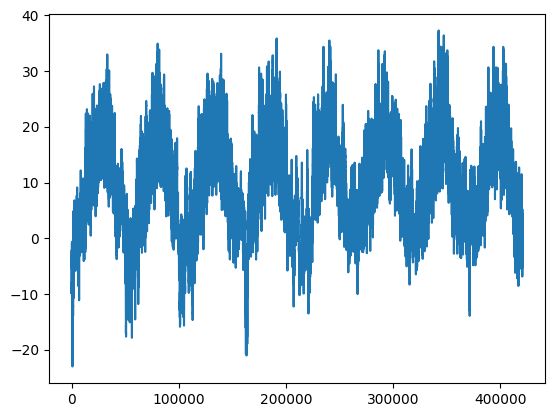

In [9]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

**처음 10일간의 기온을 그래프로 그리기**

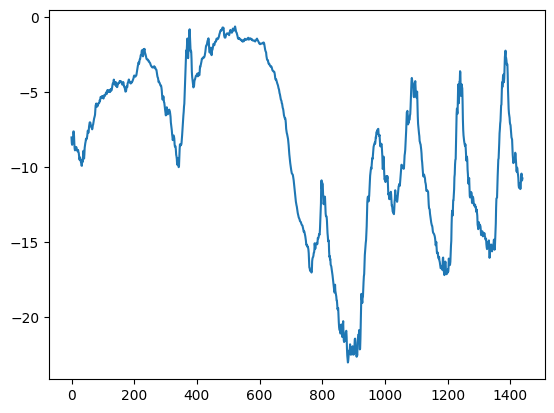

In [10]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**각 분할에 사용할 샘플 수 계산하기**

In [11]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 데이터 준비

**데이터 정규화**

In [12]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [13]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:], # data = [0,2,3,4,5,6] 이므로 앞에 3개 데이터(0,1,2)를 제외한 나머지 3부터!
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**훈련, 검증, 테스트 데이터셋 만들기**

In [14]:
sampling_rate = 6  # 10분 
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**훈련 데이터셋의 배치 크기 확인하기**

In [15]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


### 상식 수준의 기준점

**상식적인 기준 모델의 MAE 계산하기**

In [16]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


### 기본적인 머신 러닝 모델 시도해 보기

**밀집 연결 모델 훈련하고 평가하기**

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 50ms/step - loss: 12.3901 - mae: 2.7222 - val_loss: 11.1018 - val_mae: 2.6246
Epoch 2/10
819/819 [==============================] - 45s 54ms/step - loss: 8.9589 - mae: 2.3533 - val_loss: 11.7151 - val_mae: 2.7127
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 8.2232 - mae: 2.2574 - val_loss: 10.7839 - val_mae: 2.5956
Epoch 4/10
819/819 [==============================] - 42s 50ms/step - loss: 7.7638 - mae: 2.1927 - val_loss: 10.6627 - val_mae: 2.5781
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 7.4220 - mae: 2.1430 - val_loss: 12.7550 - val_mae: 2.8344
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 7.1796 - mae: 2.1072 - val_loss: 11.4979 - val_mae: 2.6705
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 6.9674 - mae: 2.0747 - val_loss: 11.6370 - val_mae: 2.6957
Epoch 8/10
819/819 [==============================] - 

**결과 그래프 그리기**

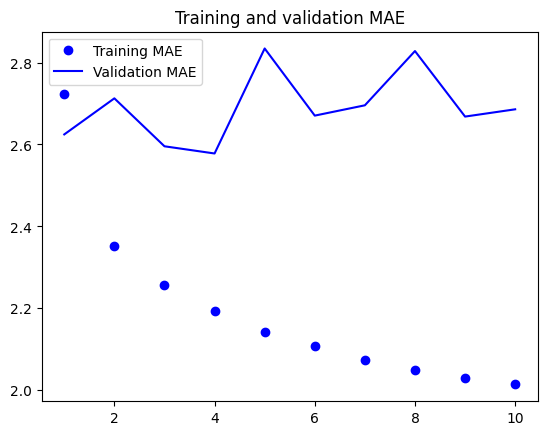

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 1D 합성곱 모델 시도해 보기

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 54ms/step - loss: 20.6653 - mae: 3.5726 - val_loss: 15.7221 - val_mae: 3.1335
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 15.2640 - mae: 3.1027 - val_loss: 15.6974 - val_mae: 3.1268
Epoch 3/10
819/819 [==============================] - 44s 53ms/step - loss: 14.2038 - mae: 2.9922 - val_loss: 14.6315 - val_mae: 3.0270
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 13.5300 - mae: 2.9169 - val_loss: 14.2433 - val_mae: 2.9874
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 12.9885 - mae: 2.8562 - val_loss: 15.0590 - val_mae: 3.0667
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 12.5395 - mae: 2.8026 - val_loss: 14.2626 - val_mae: 2.9753
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 12.1643 - mae: 2.7586 - val_loss: 15.3104 - val_mae: 3.1068
Epoch 8/10
819/819 [============================

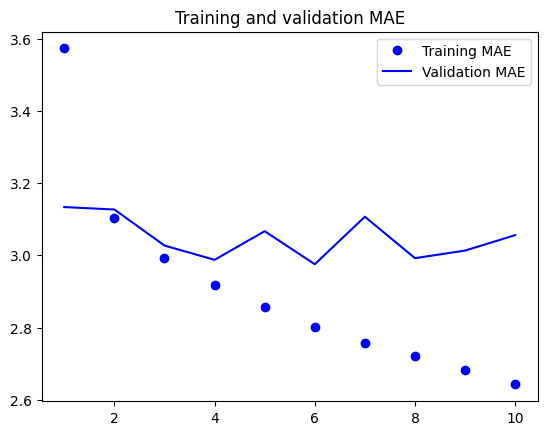

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 첫 번째 순환 신경망

**간단한 LSTM 기반 모델**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
452/819 [===============>..............] - ETA: 14s - loss: 58.5266 - mae: 5.7627

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 순환 신경망 이해하기

**넘파이로 구현한 간단한 RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### 케라스의 순환 층

**어떤 길이의 시퀀스도 처리할 수 있는 RNN 층**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**마지막 출력 스텝만 반환하는 RNN 층**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**전체 출력 시퀀스를 반환하는 RNN 층**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**스태킹(stacking) RNN 층**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## 순환 신경망의 고급 사용법

### 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

**드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 17s 18ms/step - loss: 27.8302 - mae: 3.8852 - val_loss: 9.9197 - val_mae: 2.4421
Epoch 2/50
819/819 [==============================] - 15s 18ms/step - loss: 14.7294 - mae: 2.9779 - val_loss: 10.0012 - val_mae: 2.4524
Epoch 3/50
819/819 [==============================] - 15s 18ms/step - loss: 13.9053 - mae: 2.8905 - val_loss: 9.7905 - val_mae: 2.4306
Epoch 4/50
819/819 [==============================] - 15s 18ms/step - loss: 13.2728 - mae: 2.8218 - val_loss: 9.2261 - val_mae: 2.3659
Epoch 5/50
819/819 [==============================] - 15s 19ms/step - loss: 12.7657 - mae: 2.7694 - val_loss: 9.5253 - val_mae: 2.4081
Epoch 6/50
819/819 [==============================] - 15s 19ms/step - loss: 12.2899 - mae: 2.7184 - val_loss: 9.3455 - val_mae: 2.3839
Epoch 7/50
819/819 [==============================] - 15s 19ms/step - loss: 11.9756 - mae: 2.6825 - val_loss: 9.7602 - val_mae: 2.4408
Epoch 8/50
819/819 [==============================] - 

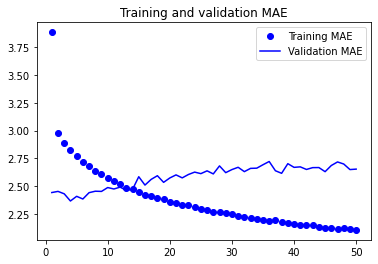

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### 스태킹 순환 층

**드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
# x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 23s 24ms/step - loss: 23.8203 - mae: 3.6085 - val_loss: 9.1113 - val_mae: 2.3265
Epoch 2/50
819/819 [==============================] - 19s 24ms/step - loss: 13.4428 - mae: 2.8387 - val_loss: 8.9302 - val_mae: 2.3205
Epoch 3/50
819/819 [==============================] - 20s 24ms/step - loss: 12.4980 - mae: 2.7414 - val_loss: 9.3066 - val_mae: 2.3674
Epoch 4/50
819/819 [==============================] - 20s 24ms/step - loss: 11.7165 - mae: 2.6547 - val_loss: 9.7335 - val_mae: 2.4234
Epoch 5/50
819/819 [==============================] - 21s 25ms/step - loss: 11.0335 - mae: 2.5730 - val_loss: 9.1506 - val_mae: 2.3421
Epoch 6/50
819/819 [==============================] - 20s 25ms/step - loss: 10.4060 - mae: 2.5011 - val_loss: 10.8818 - val_mae: 2.5821
Epoch 7/50
819/819 [==============================] - 20s 25ms/step - loss: 9.7572 - mae: 2.4213 - val_loss: 10.0641 - val_mae: 2.4677
Epoch 8/50
819/819 [==============================] - 

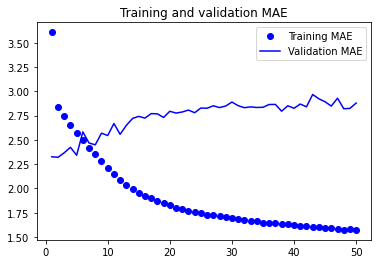

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 양방향 RNN 사용하기

시퀀스를 거꾸로 뒤집어 LSTM 모델 훈련하기 (책에는 없음)

In [ ]:
def train_generator():
    while True:
        for samples, targets in train_dataset:
            yield samples[:, ::-1, :], targets

def val_generator():
    while True:
        for samples, targets in val_dataset:
            yield samples[:, ::-1, :], targets
        
train_gen = train_generator()
val_gen = val_generator()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=819,
                    validation_data=val_gen,
                    validation_steps=410)

Epoch 1/10
819/819 [==============================] - 17s 19ms/step - loss: 34.4291 - mae: 4.5078 - val_loss: 18.8545 - val_mae: 3.4016
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 22.1811 - mae: 3.6915 - val_loss: 17.3549 - val_mae: 3.2415
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 20.1641 - mae: 3.5055 - val_loss: 16.4726 - val_mae: 3.1400
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 19.4260 - mae: 3.4325 - val_loss: 15.1944 - val_mae: 3.0632
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 16.4530 - mae: 3.1715 - val_loss: 12.5819 - val_mae: 2.7369
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 14.9640 - mae: 3.0180 - val_loss: 12.3661 - val_mae: 2.7029
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 13.9965 - mae: 2.9188 - val_loss: 13.3859 - val_mae: 2.8222
Epoch 8/10
819/819 [============================

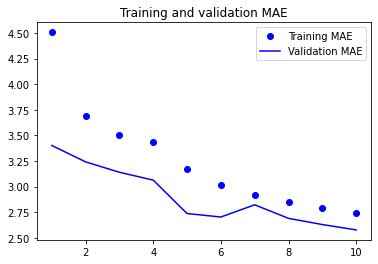

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**양방향 LSTM 모델 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 25s 27ms/step - loss: 27.5711 - mae: 3.7582 - val_loss: 10.9142 - val_mae: 2.5547
Epoch 2/10
819/819 [==============================] - 21s 25ms/step - loss: 9.5186 - mae: 2.4085 - val_loss: 10.1476 - val_mae: 2.4799
Epoch 3/10
819/819 [==============================] - 21s 25ms/step - loss: 8.5681 - mae: 2.2782 - val_loss: 9.8487 - val_mae: 2.4442
Epoch 4/10
819/819 [==============================] - 21s 25ms/step - loss: 8.0482 - mae: 2.2116 - val_loss: 10.2152 - val_mae: 2.4823
Epoch 5/10
819/819 [==============================] - 21s 25ms/step - loss: 7.6664 - mae: 2.1611 - val_loss: 10.3464 - val_mae: 2.4819
Epoch 6/10
819/819 [==============================] - 21s 25ms/step - loss: 7.3586 - mae: 2.1188 - val_loss: 10.7364 - val_mae: 2.5336
Epoch 7/10
819/819 [==============================] - 21s 25ms/step - loss: 7.1247 - mae: 2.0830 - val_loss: 10.9647 - val_mae: 2.5570
Epoch 8/10
819/819 [==============================] - 2

### 더 나아가서

## 요약